In [16]:
import numpy as np
import random
from numpy.linalg import inv
from numpy.linalg import pinv
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import copy
import random

In [2]:
# This part of the code implements live plotting:

from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data_dict, title, ylabel=None, xlabel=None, figsize=(7,5)):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show();

In [3]:
# defining the graph (weighted with rewards):

R = torch.IntTensor([[0,-100,-100,-100,-5,-100],
                    [-100,0,-100,-5,-100,100],
                    [-100,-100,0,-5,-100,-100],
                    [-100,-5,-5,0,-5,-100],
                    [-5,-100,-100,-5,0,100],
                    [-100,-5,-100,-100,-5,100]])

NumbertoSAPair = torch.IntTensor([[0, 0],[0,4],[1,1],[1,3],[1,5],
                               [2,2],[2,3],[3,1],[3,2],[3,3],
                               [3,4],[4,0],[4,3],[4,4],[4,5],
                               [5,1],[5,4],[5,5]])

AlenVec = torch.IntTensor([2,3,2,4,4,3])

# Inverse mapping: Given state-action pair, what is the curresponding number:
SAPairtoNumber = -1*torch.ones((6,6))

for i in range(len(NumbertoSAPair)):
    i1 = NumbertoSAPair[i,0].item()
    i2 = NumbertoSAPair[i,1].item()
    SAPairtoNumber[i1,i2]=i
    
StaActLen = torch.sum(AlenVec).item(); # Total number of state action pairs

In [4]:
def compute_Bellman_error(q_table, beta, noise):

    #Initialize Bellman error to 0:
    BE = torch.zeros(StaActLen) # initialiser BE_Zap avec des 0
    
    for jj in range(StaActLen): # pour tous les state-action possibles

        x = NumbertoSAPair[jj,0] # x = state
        a = NumbertoSAPair[jj,1] # a = action

        # Calculate E[max_u Q(X_{t+1},u) | X_t=x, A_t = a]:
        max_Qfun_xtp1_Zap = 0; # max_Qfun_xtp1_Zap initialisé à 0
        NumOfXtp1 = 0; # NumOfXtp1 initialisé à 0
        for ll in range(StaActLen): # pour tous les state-action possibles l
            if(NumbertoSAPair[ll,0] == x): # si l part de x
                xplus1 = NumbertoSAPair[ll,1] # xplus1 prend action
                max_Qfun_xtp1_Zap = max_Qfun_xtp1_Zap + torch.max(q_table[xplus1]) # max_Qfun_xtp1_Zap += max q_table à partir de action
                NumOfXtp1 = NumOfXtp1 + 1 # NumOfXtp1++
        max_Qfun_xtp1_Zap = max_Qfun_xtp1_Zap/NumOfXtp1 # max_Qfun_xtp1_Zap /= NumOfXtp1 (ie on prend l'average de toutes les greedy policies à partir de x)

        # BE(x,a) = R(x,a) + beta*E[max_u Q(X_{t+1},u) | X_t=x, A_t = a] - Q(x,a)
        BE[jj] = R[x,a] + beta*((1-noise)*torch.max(q_table[a]) +  noise*max_Qfun_xtp1_Zap) - q_table[x,a]

    # MaximalBellmanError = max_{x,a} BE(x,a):  
    return torch.max(abs(BE))

In [5]:
import math

def epsilon_greedy_policy(x, adjacencyMatrix, QTable, epsilon=0, environmentAwareness=False):
    """
    Returns action a (:= next wanted step in this problem)
    Takes greedy action with proba 1-epsilon
    adjacencyMatrix is the weighted reward matrix with -100 where no edges
    it will not be taken into account if environmentAwareness=False (then agent can choose -100 edges)
    """
    r = np.random.rand()
    if not environmentAwareness:
        if r > epsilon:
            return torch.argmax(QTable[x])
        else:
            return np.random.choice(range(QTable[x].shape[0]))
    else:
        if r > epsilon:
            imax = -1
            Qmax = -1 * math.inf
            for i in range(QTable[x].shape[0]):
                if adjacencyMatrix[x][i] > -100 and QTable[x][i] > Qmax:
                    imax = i
                    Qmax = QTable[x][i]
            assert imax > -1, "Error : no possible action"
            return imax
        
        else:
            available = []
            for i in range(adjacencyMatrix[x].shape[0]):
                if adjacencyMatrix[x][i] > -100:
                    available.append(i)
            assert not len(available) == 0, "Error : no possible action"
            return np.random.choice(available)

In [6]:
def take_action(x, a, adjacencyMatrix, environmentAwareness=True, randomness=0.5):
    """
    Environment response to the action a from state x, returns: newState, reward
    when environmentAwareness=True, only possible actions will be randomly taken in case of random failure
    """
    r = np.random.rand()
    if not environmentAwareness:
        if r > randomness:
            return a, adjacencyMatrix[x][a]
        else:
            aa = np.random.choice(range(adjacencyMatrix[x].shape[0]))
            return aa, adjacencyMatrix[x][aa]
    else:
        available = []
        for i in range(adjacencyMatrix[x].shape[0]):
            if adjacencyMatrix[x][i] > -100:
                available.append(i)
        assert not len(available) == 0, "Error : no possible action"
        if r > randomness:
            assert a in available, "Error : the action in not possible"
            return a, adjacencyMatrix[x][a]
        else:
            aa = np.random.choice(available)
            return aa, adjacencyMatrix[x][aa]

In [517]:
class Q_function(nn.Module):
    def __init__(self):
        super(Q_function, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(StaActLen, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def init_weights(self):
        nn.init.constant(self.fc.weight, 0)
    
    def num_params(self):
        return sum(p.numel() for p in self.parameters())
        
    def evaluate(self, x):
        with torch.no_grad():
            return self.fc(x)
        
    def forward(self, x):
        return self.fc(x)
    
    def update_A_hat(self, A_hat, gammat, psixtat, psixtp1_OptAct, beta):
        giga_tensor = torch.Tensor()
        for f in self.parameters():
            self.zero_grad()
            forward1 = self.forward(psixtat)
            forward1.backward()
            grad1 = copy.deepcopy(f.grad)
            
            self.zero_grad()
            forward2 = self.forward(psixtp1_OptAct)
            forward2.backward()
            grad2 = copy.deepcopy(f.grad)

            giga_tensor = torch.cat((giga_tensor, (-grad1 + beta*grad2).view(-1)))
        
        A = torch.ger(psixtat, giga_tensor)
        
        A_hat = A_hat + gammat*(A - A_hat)

        return A_hat

    def update_parameters(self, A_hat, psixtat, alphat, dt):
        Ainv_ZapQ = torch.Tensor(np.linalg.pinv(A_hat.detach().numpy()))
        big_vector = alphat*(Ainv_ZapQ @ psixtat)*dt
        id = 0
        for f in self.parameters():
#             print("WEIGHTS :")
#             print(f.data)
            f.data = f.data - big_vector[id : id + f.data.numel()].view(f.data.shape)
#             print("UPDATE WEIGHTS :")
#             print(f.data)
            id += f.data.numel()
    

In [518]:
# Zap Q algorithm:
def Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle=None):
    """
    /!\: Not self-contained, will only work with R for now
    Plots every t_step iteration, on the go if livePlot=True (alterates wall-clock performance)
    policyRandomness : epsilon of epsilon greedy policy
    environmentRandomness : noise of environment (proba of going to a random state)
    """
    
    dataplot = collections.defaultdict(list) # history of Bellman Errors to plot
    xt = xStart; # start in state 0
    noise = environmentRandomness
    
    Q = Q_function()
    
    # Initialize the Matrix gain for Zap Q:
    A_ZapQ = 10*torch.eye(StaActLen, Q.num_params())
    
    # Initialize the parameter vector for Zap Q:
    #Qthetat_ZapQ = torch.rand(StaActLen);

    # Initialize the Q function for Zap Q:
    Qfun_ZapQ = torch.zeros((6,6))

    # Q-learning begins here:

    for t in range(T):
        
        if policyRandomness < 0:
            epsilon = 1./(t+1)
        else:
            epsilon = policyRandomness
        # ChooseAction will return the random action chosen in the current state AND the next state
        #xtp1at_m = ChooseAction(xt,noise,Qfun_ZapQ)
        at = epsilon_greedy_policy(xt,
                                   R,
                                   Qfun_ZapQ,
                                   epsilon=epsilon,
                                   environmentAwareness=policyEnvironmentAwareness)
        xtp1, _ = take_action(xt,
                              at,
                              R,
                              environmentAwareness=environmentEnvironmentAwareness,
                              randomness=environmentRandomness)


        # Defining the stepsizes:
        alphat = 1./(t+2); # stepsize for parameter recursion
        gammat = np.power((t+1),-rho) # stepsize for matrix gain recursion

        num_sa_pair = int(SAPairtoNumber[xt][at]) # Mapping [S A] -> the curresponding number

        # Watkins' basis: Column vector with 1 at (x,a) and 0 elsewhere:
        psixtat = torch.zeros(StaActLen)
        psixtat[num_sa_pair] = 1 # Basis are indicator functions

        # Watkins' basis evaluated at next state and the optimal policy:
        # Step 1: It takes values 1 at state-action pairs corresponding to xtp1, and all feasible actions
        Qxtp1_Zap = torch.zeros(StaActLen)
        for jj in range(6):
            if SAPairtoNumber[xtp1,jj]>=0: # Is the action feasible?
                psixtp1 = torch.zeros(StaActLen)
                ind = int(SAPairtoNumber[xtp1,jj])
                psixtp1[ind] = 1 # Take value 1
                Qxtp1_Zap[ind] = Q.evaluate(psixtp1)

        # Zap Q-learning step:

        # Q(X_t,A_t):
        Qxt_Zap = Q.evaluate(psixtat)
        #Qxt_Zap = torch.dot(Qthetat_ZapQ,psixtat)

        # Q(X_t+1,a) with all feasible a's; Need to take minimum over all 'a' later:

        # Optimal action for state xtp1, given the current parameter estimate:
        OptAct_xtp1 = torch.argmax(Qxtp1_Zap)
        # Q-value at xtp1 and the optimal action:
        # max_Qxtp1_Zap = torch.max(Qxtp1_Zap)

        # Basis function evaluated at xtp1 and the corresponding optimal action
        psixtp1_OptAct = torch.zeros(StaActLen);
        psixtp1_OptAct[OptAct_xtp1] = 1;
        
        max_Qxtp1_Zap = Q.evaluate(psixtp1_OptAct)

        # Zap Q-learning begins here:

        # Estimating the A(\theta_t) matrix:
        psixtat.requires_grad = True
        psixtp1_OptAct.requires_grad = True
        
        A_ZapQ = Q.update_A_hat(A_ZapQ, gammat, psixtat, psixtp1_OptAct, beta)
        

        # Q update for SNR 2 (a) gain:
        
        dt = R[xt,at] + beta*max_Qxtp1_Zap - Qxt_Zap
        Q.update_parameters(A_ZapQ, psixtat, alphat, dt)
        
        #Q.state_dict() =  Q.state_dict()  - alphat*(Ainv_ZapQ @ psixtat)*((R[xt,at] + beta*max_Qxtp1_Zap - Qxt_Zap))
        #tmp = tmp - alphat*(Ainv_ZapQ @ psixtat)*((R[xt,at] + beta*max_Qxtp1_Zap - Qxt_Zap))

        # Zap Q-learning ends here



        xt = xtp1;

        # The code from here is to calculate the Bellman error at this iteration

        if((t%t_step)==0):
            for jj in range(StaActLen):
                psixtat = torch.zeros(StaActLen)
                psixtat[jj] = 1
                Qfun_ZapQ[NumbertoSAPair[jj,0],NumbertoSAPair[jj,1]] = Q.evaluate(psixtat)
            # MaximalBellmanError = max_{x,a} BE(x,a):
            # print(Qfun_ZapQ)
            dataplot['Zap_Q'].append(compute_Bellman_error(Qfun_ZapQ, beta, noise))
            if livePlot:
                live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='t')

            # End of calculating Bellman Error
    if not livePlot:
        live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='t')
    return Qfun_ZapQ

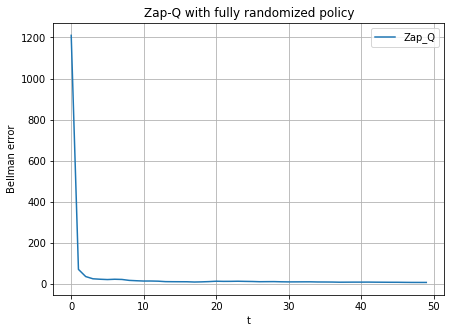

tensor([[309.2089,   0.0000,   0.0000,   0.0000, 374.6497,   0.0000],
        [  0.0000, 375.6976,   0.0000, 303.0224,   0.0000, 478.8085],
        [  0.0000,   0.0000, 235.3312, 286.3682,   0.0000,   0.0000],
        [  0.0000, 368.3098, 242.9954, 305.4087, 372.8086,   0.0000],
        [304.4290,   0.0000,   0.0000, 300.4796, 378.0492, 486.0834],
        [  0.0000, 379.9584,   0.0000,   0.0000, 382.7130, 490.6148]])


In [519]:
Q = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=1,
          environmentRandomness=0.2,
          T=5000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot = True,
          plotTitle='Zap-Q with fully randomized policy')

print(Q)

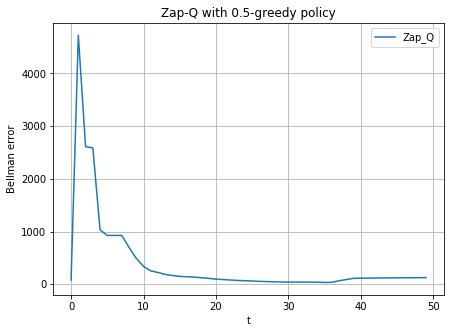

tensor([[148.9499,   0.0000,   0.0000,   0.0000, 189.3311,   0.0000],
        [  0.0000, 283.5586,   0.0000, 182.9939,   0.0000, 351.9490],
        [  0.0000,   0.0000, 136.7108, 201.7180,   0.0000,   0.0000],
        [  0.0000, 178.2336, 173.0916, 155.6979, 326.8702,   0.0000],
        [143.5823,   0.0000,   0.0000, 301.0722, 226.4694, 357.8990],
        [  0.0000, 151.4387,   0.0000,   0.0000, 352.9048, 350.8457]])


In [511]:
Q = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.5,
          environmentRandomness=0.2,
          T=5000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle='Zap-Q with 0.5-greedy policy')

print(Q)

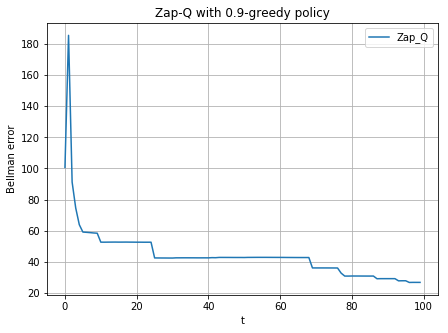

tensor([[316.0599,   0.0000,   0.0000,   0.0000, 377.2546,   0.0000],
        [  0.0000, 383.0108,   0.0000, 305.1011,   0.0000, 489.2355],
        [  0.0000,   0.0000, 208.8543, 285.8795,   0.0000,   0.0000],
        [  0.0000, 366.1029, 260.3257, 306.4659, 371.7315,   0.0000],
        [302.9936,   0.0000,   0.0000, 300.7299, 383.5936, 486.8291],
        [  0.0000, 385.4371,   0.0000,   0.0000, 384.9230, 495.7785]])


In [11]:
Q = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.1,
          environmentRandomness=0.2,
          T=5000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle='Zap-Q with 0.9-greedy policy')

print(Q)

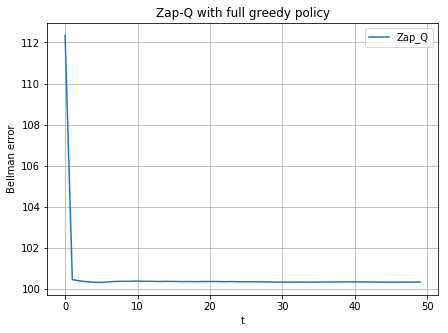

tensor([[-0.3286,  0.0000,  0.0000,  0.0000, -0.3286,  0.0000],
        [ 0.0000, -0.3286,  0.0000, -0.3286,  0.0000, -0.3286],
        [ 0.0000,  0.0000, -0.3286, -0.3286,  0.0000,  0.0000],
        [ 0.0000, -0.3286, -0.3286, -0.3286, -0.3286,  0.0000],
        [-0.3286,  0.0000,  0.0000, -0.3286, -0.3286, -0.3286],
        [ 0.0000, -0.3286,  0.0000,  0.0000, -0.3286, -0.3286]])


In [516]:
Q = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0,
          environmentRandomness=0.2,
          T=5000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle='Zap-Q with full greedy policy')

print(Q)

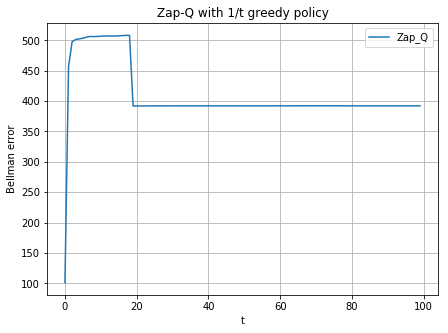

tensor([[ 4.9313e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  3.7157e+02,
          0.0000e+00],
        [ 0.0000e+00,  3.7440e+02,  0.0000e+00,  1.6631e+02,  0.0000e+00,
          4.8910e+02],
        [ 0.0000e+00,  0.0000e+00,  5.4810e-01,  2.7608e+02,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  3.5105e+02,  6.5072e-01,  7.8533e-01,  3.7027e+02,
          0.0000e+00],
        [ 5.1703e-01,  0.0000e+00,  0.0000e+00,  2.4226e-01,  6.4063e-01,
          4.8667e+02],
        [ 0.0000e+00,  3.8767e+02,  0.0000e+00,  0.0000e+00, -7.2091e+00,
          4.9586e+02]])


In [13]:
Q = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=-1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle='Zap-Q with 1/t greedy policy')

print(Q)

In [14]:
# vanilla Q learning :

def vanilla_Q_learning(livePlot=True,
                       initial_lr = 1.0,
                       min_lr = 0.003,
                       gamma = 0.8,
                       t_max = 100000,
                       iter_max = 10,
                       policyRandomness = 0,
                       policyEnvironmentAwareness = True,
                       environmentEnvironmentAwareness = True,
                       environmentRandomness = 0.2,
                       seed=0,
                       plotTitle=None):
    np.random.seed(seed)
    BE = np.zeros((6,6))
    xt1 = 4
    dataplot = collections.defaultdict(list)
    #print ('----- using Q Learning -----')
    q_table = np.zeros((6,6))
    for i in range(iter_max):
        obs = xt1
        total_reward = 0
        ## alpha: learning rate is decreased at each step
        alpha = max(min_lr, initial_lr * (0.85 ** (i//100)))
        for j in range(t_max):
            xt0 = xt1
            action = epsilon_greedy_policy(xt0,
                                   R,
                                   q_table,
                                   epsilon=policyRandomness,
                                   environmentAwareness=policyEnvironmentAwareness)
            xt1, reward = take_action(xt0,
                                  action,
                                  R,
                                  environmentAwareness=environmentEnvironmentAwareness,
                                  randomness=environmentRandomness)
            total_reward += (gamma ** j) * reward
            # update q table
            q_table[xt0][action] = q_table[xt0][action] + alpha * (reward + gamma *  np.max(q_table[xt1]) - q_table[xt0][action])
        #print('Iteration #%d -- Total reward = %d.' %(i+1, total_reward))
            if j%10000 == 0:
                #print(compute_Bellman_error(q_table, gamma, environmentRandomness))
                dataplot['Vanilla_Q'].append(compute_Bellman_error(q_table, gamma, environmentRandomness))
                if livePlot:
                    live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='t')
    #solution_policy = np.argmax(q_table, axis=1)
    return q_table
    #solution_policy_scores = [run_episode(env, solution_policy, False) for _ in range(100)]
    #print("Average score of solution = ", np.mean(solution_policy_scores))
    # Animate it
    #run_episode(env, solution_policy, True)

In [15]:
q_table = vanilla_Q_learning(livePlot=True,
                       initial_lr = 1.0,
                       min_lr = 0.003,
                       gamma = 0.8,
                       t_max = 1000000, # one million iterations instead of 100 000
                       iter_max = 1, # one episode, we don't need to use episodes here
                       policyRandomness = 1, # full random
                       policyEnvironmentAwareness = True,
                       environmentEnvironmentAwareness = True,
                       environmentRandomness = 0.2,
                       plotTitle='Vanilla Q Learning - random policy')

print(q_table)

TypeError: max(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
q_table = vanilla_Q_learning(livePlot=True,
                       initial_lr = 1.0,
                       min_lr = 0.003,
                       gamma = 0.8,
                       t_max = 1000000, # one million iterations instead of 100 000
                       iter_max = 1, # one episode, we don't need to use episodes here
                       policyRandomness = 0, # full greedy
                       policyEnvironmentAwareness = True,
                       environmentEnvironmentAwareness = True,
                       environmentRandomness = 0.2,
                       seed=1,
                       plotTitle='Vanilla Q Learning - greedy policy')

print(q_table)